In [ ]:
!pip install --upgrade gensim scipy



In [ ]:
# 1. Imports and helper functions
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings('ignore')

# helper to clean text
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [ ]:
# 2. Load dataset
DATA_PATH = '/content/it_domain_questions.csv'
assert os.path.exists(DATA_PATH), f"Dataset not found at {DATA_PATH} - please upload it to this path."
df = pd.read_csv(DATA_PATH, encoding='utf-8')
print('Shape:', df.shape)
df.head(10)


Shape: (1200, 2)


,question,domain
0,Explain the purpose of feature scaling in mach...,Data Science
1,What is the difference between supervised and ...,Data Science
2,How is overfitting detected in a model? (examp...,Data Science
3,Explain the purpose of feature scaling in mach...,Data Science
4,What are the common evaluation metrics for cla...,Data Science
5,What is the difference between supervised and ...,Data Science
6,How is overfitting detected in a model? (examp...,Data Science
7,How is overfitting detected in a model? (examp...,Data Science
8,What are decision trees and how do they work? ...,Data Science
9,How is overfitting detected in a model? (examp...,Data Science


## 3. Exploratory Data Analysis (EDA)
We check domain distribution, word counts, top words and simple plots.

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Télécharger les ressources nécessaires
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Stopwords anglais + mots d’introduction de questions
stop_words = set(stopwords.words('english'))

# Ajouter des mots à ignorer spécifiquement pour ce dataset
question_words = {
    'explain', 'what', 'how', 'describe', 'define', 'why', 'when',
    'where', 'who', 'which', 'give', 'difference', 'purpose',
    'used', 'use', 'mean', 'example', 'examples'
}

stop_words = stop_words.union(question_words)

def clean_text(text):
    # 1. Minuscules
    text = text.lower()

    # 2. Supprimer tout ce qui est entre parenthèses
    text = re.sub(r'\(.*?\)', '', text)

    # 3. Supprimer les chiffres
    text = re.sub(r'\d+', '', text)

    # 4. Supprimer la ponctuation et caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)

    # 5. Supprimer underscores et tirets
    text = re.sub(r'[_-]', ' ', text)

    # 6. Tokenisation
    tokens = word_tokenize(text)

    # 7. Supprimer stopwords + mots de question
    tokens = [word for word in tokens if word not in stop_words]

    # 8. Reformater proprement
    return ' '.join(tokens)

# Appliquer sur le dataset
df['cleaned_question'] = df['question'].apply(clean_text)

# Afficher un aperçu du nettoyage
df[['question', 'cleaned_question']].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,question,cleaned_question
0,Explain the purpose of feature scaling in mach...,feature scaling machine learning
1,What is the difference between supervised and ...,supervised unsupervised learning
2,How is overfitting detected in a model? (examp...,overfitting detected model
3,Explain the purpose of feature scaling in mach...,feature scaling machine learning
4,What are the common evaluation metrics for cla...,common evaluation metrics classification
5,What is the difference between supervised and ...,supervised unsupervised learning
6,How is overfitting detected in a model? (examp...,overfitting detected model
7,How is overfitting detected in a model? (examp...,overfitting detected model
8,What are decision trees and how do they work? ...,decision trees work
9,How is overfitting detected in a model? (examp...,overfitting detected model


,question,domain,cleaned_question,clean_q,word_count,char_count
765,What are the benefits of version control syste...,DevOps,benefits version control systems,benefits version control systems,4,32
147,Explain cross-validation and why it is used. (...,Data Science,crossvalidation,explain crossvalidation used,1,15
797,How does Docker improve software deployment? (...,DevOps,docker improve software deployment,docker improve software deployment,4,34
564,What is the difference between GET and POST me...,Web Development,get post methods,difference get post methods,3,16
459,How does HTTPS secure communication? (example ...,Cybersecurity,https secure communication,https secure communication,3,26
432,What is a VPN and how does it work? (example 192),Cybersecurity,vpn work,vpn work,2,8
1022,What is the shared responsibility model? (exam...,Cloud Computing,shared responsibility model,shared responsibility model,3,27
313,What are common types of malware? (example 73),Cybersecurity,common types malware,common types malware,3,20


Domain counts:
domain
Data Science       240
Cybersecurity      240
Web Development    240
DevOps             240
Cloud Computing    240
Name: count, dtype: int64

Word count statistics:
count    1200.000000
mean        2.915833
std         0.794318
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: word_count, dtype: float64


,word,count
0,work,122
1,cloud,109
2,differ,79
3,concept,71
4,data,62
5,devops,58
6,testing,56
7,aws,54
8,model,52
9,learning,50


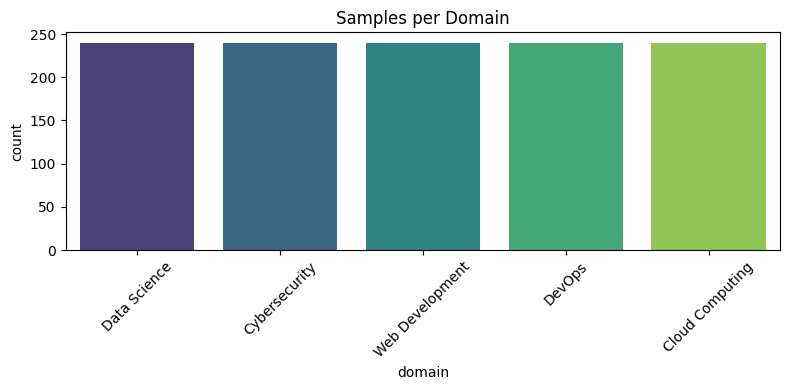

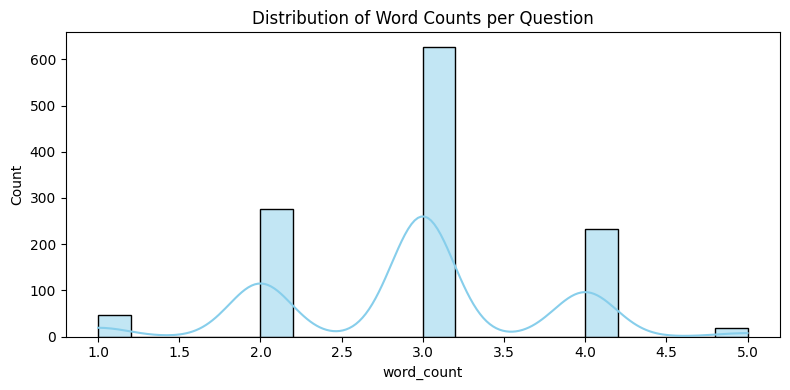

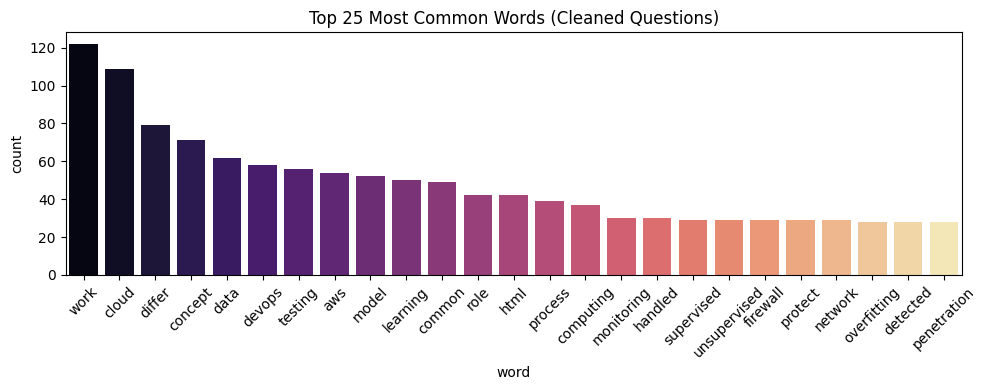

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Assurer que la colonne est bien du texte
df['cleaned_question'] = df['cleaned_question'].astype(str)

# Créer les nouvelles colonnes d'analyse
df['word_count'] = df['cleaned_question'].apply(lambda x: len(x.split()))
df['char_count'] = df['cleaned_question'].apply(len)

# Aperçu aléatoire de quelques lignes
display(df.sample(8))

# Comptage des domaines
print('Domain counts:')
print(df['domain'].value_counts())

# Statistiques sur le nombre de mots
print('\nWord count statistics:')
print(df['word_count'].describe())

# Mots les plus fréquents
all_words = ' '.join(df['cleaned_question']).split()
top_words = Counter(all_words).most_common(25)
top_words_df = pd.DataFrame(top_words, columns=['word', 'count'])
display(top_words_df.head(25))

# --- Visualisations ---

# Nombre d'exemples par domaine
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='domain', palette='viridis')
plt.title('Samples per Domain')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution du nombre de mots
plt.figure(figsize=(8, 4))
sns.histplot(df['word_count'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Word Counts per Question')
plt.tight_layout()
plt.show()

# Mots les plus fréquents
plt.figure(figsize=(10, 4))
sns.barplot(data=top_words_df, x='word', y='count', palette='magma')
plt.title('Top 25 Most Common Words (Cleaned Questions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 4. Embeddings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# --- Préparer les phrases tokenisées à partir de la version nettoyée ---
sentences = [q.split() for q in df['cleaned_question']]

use_word2vec = False
w2v_model = None
embedding_dim = 100

try:
    from gensim.models import Word2Vec
    use_word2vec = True

    # Entraîner le modèle Word2Vec
    w2v_model = Word2Vec(
        sentences,
        vector_size=embedding_dim,
        window=5,
        min_count=1,
        workers=4,
        epochs=20,
        seed=42
    )

    print('✅ Trained Word2Vec successfully.')
    print('Vocabulary size:', len(w2v_model.wv))

except Exception as e:
    print('❌ Word2Vec not available or failed to train.')
    print('Reason:', type(e).__name__, e)
    use_word2vec = False

# --- Fonction pour obtenir le vecteur d’une phrase ---
def sentence_vector_w2v(tokens, model, dim=100):
    vecs = [model.wv[t] for t in tokens if t in model.wv]
    if len(vecs) == 0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

# --- Construire la matrice d’embeddings ---
if use_word2vec and w2v_model is not None:
    X = np.vstack([sentence_vector_w2v(s, w2v_model, embedding_dim) for s in sentences])
    print('✅ Embeddings (Word2Vec) shape:', X.shape)
else:
    tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    X = tfidf.fit_tr_


✅ Trained Word2Vec successfully.
Vocabulary size: 122
✅ Embeddings (Word2Vec) shape: (1200, 100)


## 5. Modeling: Train classifiers (Logistic Regression and Random Forest)

Classes détectées : ['Cloud Computing', 'Cybersecurity', 'Data Science', 'DevOps', 'Web Development']
Train shape: (960, 100) Test shape: (240, 100)


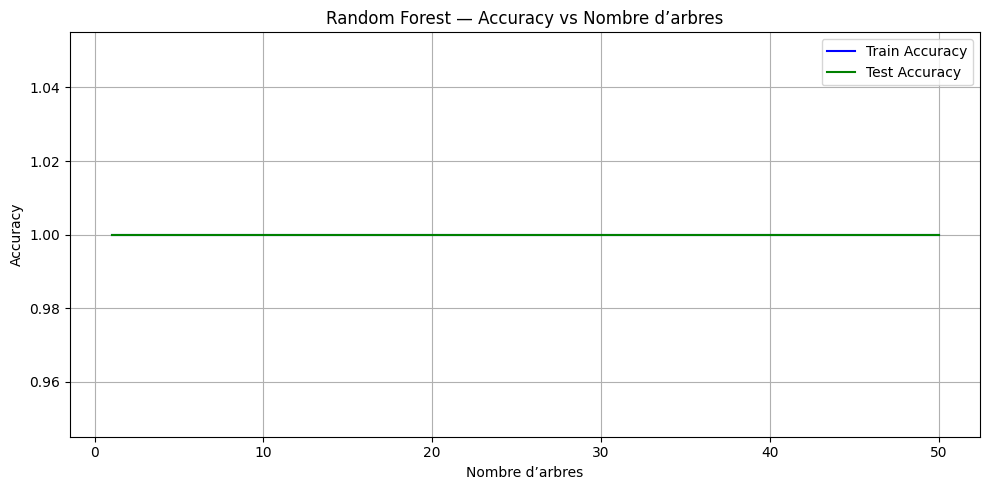

✅ Final Test Accuracy - Random Forest: 1.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# --- Encodage des étiquettes ---
le = LabelEncoder()
y = le.fit_transform(df['domain'])
print('Classes détectées :', list(le.classes_))

# --- Division du dataset ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

# --- Entraînement progressif du Random Forest ---
train_accs = []
test_accs = []

rf = RandomForestClassifier(
    n_estimators=1,
    warm_start=True,
    oob_score=True,
    random_state=42
)

n_trees = 50  # nombre total d’arbres à construire

for i in range(n_trees):
    rf.n_estimators = i + 1
    rf.fit(X_train, y_train)

    # Accuracy sur l'entraînement
    y_pred_train = rf.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_accs.append(train_acc)

    # Accuracy sur le test
    y_pred_test = rf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_accs.append(test_acc)

# --- Visualisation de la performance ---
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_trees+1), train_accs, label='Train Accuracy', color='blue')
plt.plot(range(1, n_trees+1), test_accs, label='Test Accuracy', color='green')
plt.xlabel('Nombre d’arbres')
plt.ylabel('Accuracy')
plt.title('Random Forest — Accuracy vs Nombre d’arbres')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Évaluation finale ---
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print('✅ Final Test Accuracy - Random Forest:', round(acc_rf, 4))

# 📈 Visualize accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


## 6. Evaluation: Confusion Matrix and PCA visualization

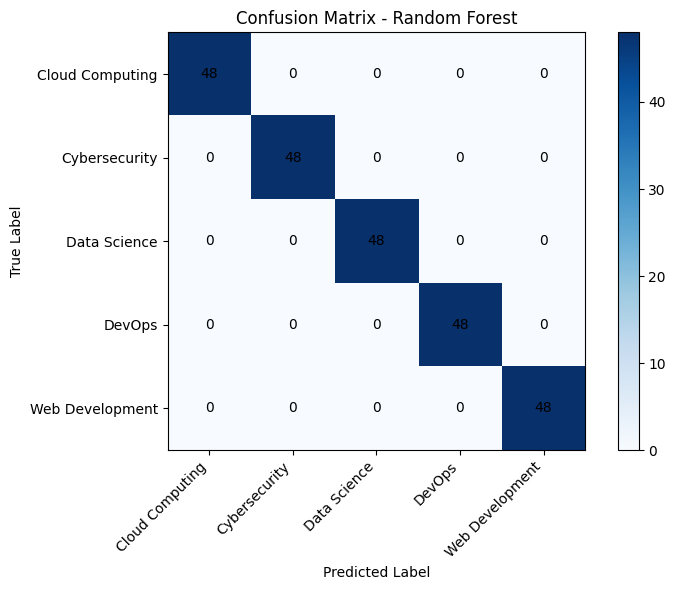

📊 Classification Report:
                 precision    recall  f1-score   support

Cloud Computing       1.00      1.00      1.00        48
  Cybersecurity       1.00      1.00      1.00        48
   Data Science       1.00      1.00      1.00        48
         DevOps       1.00      1.00      1.00        48
Web Development       1.00      1.00      1.00        48

       accuracy                           1.00       240
      macro avg       1.00      1.00      1.00       240
   weighted avg       1.00      1.00      1.00       240



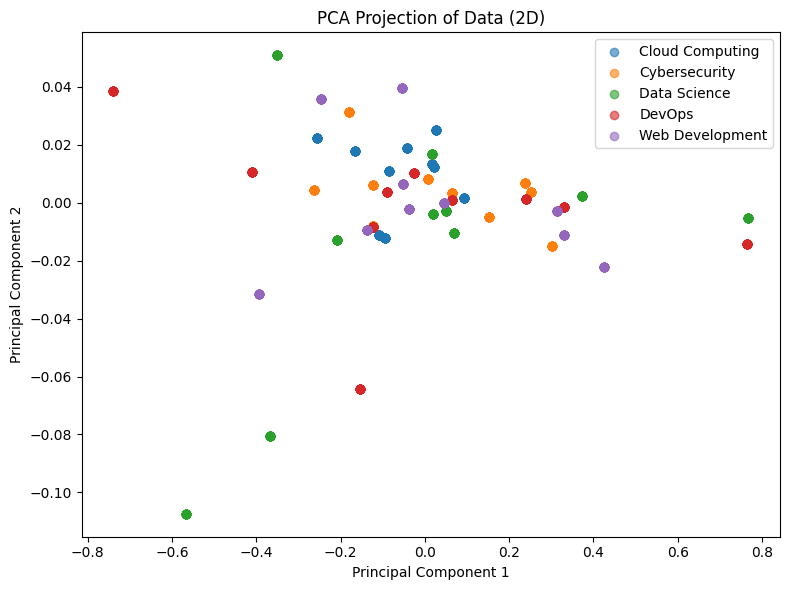

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

# --- Prédictions du modèle ---
y_pred_rf = rf.predict(X_test)

# --- Matrice de confusion ---
cmatrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
plt.imshow(cmatrix, interpolation='nearest', cmap=cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
ticks = np.arange(len(le.classes_))
plt.xticks(ticks, le.classes_, rotation=45, ha='right')
plt.yticks(ticks, le.classes_)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Ajouter les valeurs dans chaque case
for i in range(cmatrix.shape[0]):
    for j in range(cmatrix.shape[1]):
        plt.text(j, i, cmatrix[i, j], ha='center', va='center', color='black')

plt.tight_layout()
plt.show()

# --- Rapport complet de classification ---
print("📊 Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

# --- Projection PCA pour visualiser la structure des données ---
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for i, c in enumerate(le.classes_):
    mask = (y == i)
    plt.scatter(proj[mask, 0], proj[mask, 1], label=c, alpha=0.6)

plt.legend()
plt.title('PCA Projection of Data (2D)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()


## 8. Inference: sample predictions

In [ ]:
# --- 🔮 Tester le modèle sur de nouvelles questions ---

def predict_domain(question_text):
    # Nettoyer la question avec la même fonction que le dataset
    clean_q = clean_text(question_text)

    # Transformer la question selon la méthode utilisée
    if use_word2vec and w2v_model is not None:
        tokens = clean_q.split()
        vec = sentence_vector_w2v(tokens, w2v_model, embedding_dim).reshape(1, -1)
    else:
        vec = tfidf.transform([clean_q]).toarray()

    # Prédire le domaine
    pred_label = rf.predict(vec)[0]
    domain_name = le.inverse_transform([pred_label])[0]

    return domain_name

# --- 🔍 Exemple de test ---
test_questions = [
    "What is the purpose of normalization in databases?",
    "How does a firewall protect a network?",
    "Explain gradient descent in machine learning.",
    "What are the layers of the OSI model?",
    "Describe encryption and decryption process."
]

print("🔎 Model Predictions:\n")
for q in test_questions:
    domain = predict_domain(q)
    print(f"Question: {q}\n→ Predicted Domain: {domain}\n")


🔎 Model Predictions:

Question: What is the purpose of normalization in databases?
→ Predicted Domain: Data Science

Question: How does a firewall protect a network?
→ Predicted Domain: Cybersecurity

Question: Explain gradient descent in machine learning.
→ Predicted Domain: Data Science

Question: What are the layers of the OSI model?
→ Predicted Domain: Cloud Computing

Question: Describe encryption and decryption process.
→ Predicted Domain: DevOps

